<a href="https://colab.research.google.com/github/ashishrp96/Automated-Reply-Suggestion/blob/main/DBSCAN_LSTM_Model_for_combined_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial data loading and Cleaning

Insatlling Packages

In [ ]:
#Installing required packages
!pip3 install transformers
!pip3 install gensim
!pip3 install sent2vec
!pip3 install gradio

WandB insatll and login - Not Necessary for To run code

In [ ]:
# !pip install wandb
# !wandb login



     |████████████████████████████████| 1.7 MB 10.0 MB/s 
     |████████████████████████████████| 97 kB 7.5 MB/s 
     |████████████████████████████████| 180 kB 76.7 MB/s 
     |████████████████████████████████| 140 kB 71.3 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=9a1d3970bbb7537fa958a00cbfda72a11e1e958db333f60fe18e4422e153c6c1
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=2e05004ba855e3e53605dc41e29ae83d1cc768af73bf696c01af69199530038d
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or 

In [ ]:
# import wandb

# wandb.init(project="Combined-data-LSTM", entity="smartreply")

wandb: Currently logged in as: ashishrp (use `wandb login --relogin` to force relogin)


In [ ]:
#Imprting Packages
import pandas as pd
import string
import torch
import transformers
import numpy
import gensim
import sent2vec
import numpy as np
import sklearn
import matplotlib

Loading dataframes

In [ ]:
df1 = pd.read_csv("/content/drive/MyDrive/Infragistics/com_amazon_df.csv")
df2 = pd.read_csv("/content/drive/MyDrive/Infragistics/twitter_com_df.csv")
df3 = pd.read_csv("/content/drive/MyDrive/Infragistics/Custom_Dataset.csv")
df4 = pd.read_csv("/content/drive/MyDrive/Infragistics/amazonqa_com_df.csv")

In [ ]:
#Data cleaning process which removed all the punctuation mentioned and turns uppercase to lowercase uniformly this is required to predict function to take in new incoming messages.

def process(text):
    text = text.lower().replace('\n', ' ').replace('-', ' ').replace(':', ' ').replace(',', '').replace('"', '') \
          .replace("...", ".").replace("..", ".") \
          .replace("!", ".").replace("?", "") \
          .replace(";", ".").replace(":", " ")

    text = "".join(v for v in text if v not in string.punctuation).lower()
    text = text.encode("utf8").decode("ascii",'ignore')

    text = " ".join(text.split())
    return text

Adjusting custom dataset column names and dropping unnecesasry columns whihc developed when loading data into pandas dataframe

In [ ]:
df3 = df3.rename(columns={"input ": "input", "reply": "reply"})

In [ ]:
df3.input = df3.input.apply(process)
df3.reply = df3.reply.apply(process)

In [ ]:
df3

,input,reply
0,you have been late five times this month,no i wasnt
1,did you submit the timesheet for the week,no not yet
2,could you tell me why i lost my bonus last month,im not clear
3,when is the ethics and compliance training due,its due by end of this year
4,how are you doing today,good thank you
...,...,...
195,please join the zoom call,no i cant
196,please attend the zoom meeting,not sure
197,please join the zoom meeting,not sure
198,please attend the zoom call,not sure


In [ ]:
df1 = df1.drop(columns=['Unnamed: 0'])
df2 = df2.drop(columns=['Unnamed: 0'])
df4 = df4.drop(columns=['Unnamed: 0'])

# Final Dataset combining

In [ ]:
#combining all the datasets and laoding them into new dataframe and checking for null values and resetting index
df = pd.concat([df1,df2,df3,df4])
df = df.dropna()
df = df.reset_index(drop=True)

In [ ]:
df

,input,reply
0,yeah true did you know babies are really good ...,yes and they smile more when they hit the beat
1,yes it helped him smooth out his dance moves,nice do you like shakespeare
2,yes otherwise the rhymes and puns do not seem ...,yes he lived at the same time as pocahontas too
3,ha ha it was so nice chatting with you as well...,bye
4,i love it did you know bruce lee was a dancer,yes he even won a cha cha championship in 1958
...,...,...
58713,will this unit work with usb 20,yes it will
58714,is this compatible with the iconia 510 tablet,yes it is
58715,will this power supply work on my hp pavilion ...,it should
58716,are there any video out ports hdmi or vga,yes both


# Vectroization of Replies

In [ ]:
from sent2vec.vectorizer import Vectorizer

In [ ]:
#divided data into 80 chunks to not overload RAM
chunks =80
split_df = np.array_split(df, chunks)

vectorizer = Vectorizer()
vector_list=[]
for i in range(chunks):
    print(i)
    vectorizer.bert(split_df[i].reply)
    vectors = vectorizer.vectors
    vector_list.append(vectors)

vec_df= pd.DataFrame(np.concatenate(vector_list))

0


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


1


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


2


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


3


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


4


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


5


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


6


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


7


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


8


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


9


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


10


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


11


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


12


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


13


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


14


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


15


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


16


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


17


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


18


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


19


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


20


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


21


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


22


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


23


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


24


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


25


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


26


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


27


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


28


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


29


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


30


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


31


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


32


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


33


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


34


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


35


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


36


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


37


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


38


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


39


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


40


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


41


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


42


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


43


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


44


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


45


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


46


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


47


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


48


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


49


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


50


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


51


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


52


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


53


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


54


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


55


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


56


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


57


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


58


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


59


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


60


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


61


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


62


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


63


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


64


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


65


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


66


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


67


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


68


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


69


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


70


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


71


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


72


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


73


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


74


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


75


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


76


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


77


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


78


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


79


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#reply message vector dataframe
vec_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
0,0.011698,-0.009978,0.232241,-0.109353,-0.063124,-0.031153,0.142093,0.373534,-0.246140,-0.253079,0.050282,0.113324,0.048248,0.223108,0.133037,0.140419,-0.108332,0.194521,0.159043,-0.137016,-0.008061,-0.087190,0.087988,-0.101893,0.016463,-0.002137,-0.097974,-0.108531,0.099954,0.007905,0.011992,0.115129,0.062236,-0.031406,0.017687,-0.001000,0.123482,-0.027140,0.038712,-0.090667,...,0.012084,0.068381,-0.031721,0.204321,-0.035866,-0.013542,-0.036486,-0.004128,-0.111660,-0.179531,-0.083201,0.118168,0.159075,-0.080376,-0.092351,0.194844,0.109870,-0.154285,0.178739,0.072434,-0.042648,0.077002,-0.140484,0.088211,-7.469146,-0.208786,-0.003727,-0.136196,-0.064850,-0.052691,-0.013031,-0.237993,0.050927,0.093184,0.247380,0.012576,-0.179785,-0.086447,0.233790,0.168389
1,-0.236718,-0.208666,0.185628,-0.246107,-0.277019,-0.107113,0.140014,0.351005,-0.230587,-0.203952,0.039531,0.036270,0.019882,0.110994,-0.013145,-0.057712,-0.046049,0.137436,0.156039,-0.314000,-0.110370,-0.144429,0.109298,-0.212501,-0.108511,-0.091376,0.029640,0.293453,0.205703,-0.155877,0.017583,0.096799,-0.149595,0.027292,-0.023930,0.102912,0.048410,0.171295,0.183695,0.045348,...,0.011328,0.140612,0.249759,0.267953,-0.040426,0.012962,0.111998,-0.061950,-0.163904,-0.123923,-0.040702,0.121908,0.012850,0.131952,-0.062746,0.315432,0.433121,0.229586,0.304306,0.132315,0.075651,0.170724,-0.193814,0.310101,-7.371449,-0.000294,0.075549,-0.025908,-0.102871,-0.209926,0.032284,-0.520516,0.076086,-0.047979,0.183337,-0.167964,-0.052068,0.012188,0.290915,0.123130
2,-0.099148,0.079598,-0.090098,-0.029008,0.133783,-0.126128,0.256671,0.415596,-0.321810,-0.291853,0.065308,0.010045,-0.289694,0.435391,-0.024975,0.123009,-0.212324,0.140278,0.093204,-0.136597,-0.120857,-0.172497,0.023024,-0.042263,-0.122625,-0.032601,0.013511,-0.136403,0.016311,0.163220,-0.023601,0.174621,-0.106772,-0.106252,-0.259689,-0.199156,-0.003424,0.010400,0.031651,0.145710,...,0.067301,0.001931,-0.002405,0.227487,-0.035465,-0.306164,-0.027824,-0.024417,-0.252958,-0.115553,0.198536,0.061869,0.148897,0.081488,-0.010187,0.188412,0.065888,-0.073638,0.116670,-0.030121,-0.060413,-0.112492,-0.095338,0.013142,-6.787653,-0.151627,-0.008827,-0.187314,-0.207912,-0.120844,0.100110,-0.075291,-0.050871,-0.126465,0.213949,-0.059414,-0.247543,-0.115085,0.529928,0.164276
3,-0.211480,-0.301197,0.247927,-0.216570,-0.212242,-0.177212,0.051534,0.266697,-0.061163,-0.201506,0.002267,0.041970,0.108183,0.054754,-0.086584,-0.139323,0.053472,0.094726,0.139125,-0.392649,-0.094483,0.048827,0.122976,-0.116504,-0.209466,-0.031016,-0.007196,0.352799,0.202199,-0.032252,0.053627,0.055740,-0.182851,0.052534,-0.016557,0.208643,0.098228,0.186970,0.219639,-0.091853,...,0.021912,0.165649,0.180053,0.402281,-0.019342,-0.095933,0.227408,-0.028686,-0.148826,-0.129227,0.119850,0.005270,-0.056055,0.174855,-0.169975,0.192011,0.399170,0.042435,0.233225,0.294143,0.174023,0.450727,-0.199132,0.461695,-6.190471,0.001057,0.276080,0.038007,-0.103747,-0.035566,0.084443,-0.381814,0.175004,-0.023311,0.308794,-0.213306,0.055860,0.112460,0.360917,0.077645
4,-0.277089,0.093250,0.140589,-0.085011,-0.156058,-0.204890,0.205727,0.411625,-0.256046,-0.129020,0.160804,-0.063405,0.037510,0.190656,0.048773,0.116629,-0.205966,0.068937,0.126215,-0.141895,-0.082778,-0.216803,-0.017607,-0.057999,-0.051451,0.081877,-0.129266,-0.078201,0.018437,0.128838,0.120184,0.064937,0.156958,0.007233,-0.033782,-0.116488,0.147963,0.136849,0.129741,0.035646,...,-0.117521,-0.050756,-0.052455,0.137278,0.080083,-0.023337,-0.041632,-0.103936,-0.183660,-0.094217,0.023748,-0.040430,0.094544,0.039219,-0.053657,0.076662,0.432028,0.010391,0.110503,0.008272,-0.099411,0.087543,0.059273,0.032101,-6.881810,-0.230413,0.074036,-0.109202,-0.069963,0.008

# DBSCAN Clustering

In [ ]:
#Loading Packages
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from collections import Counter
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

In [ ]:
eps_num = 0.0044
print("Taking EPS as", eps_num)
# Compute DBSCAN
db = DBSCAN(eps=eps_num, min_samples=4, metric='cosine', n_jobs=4).fit(vec_df)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Taking EPS as 0.0044
Estimated number of clusters: 1016
Estimated number of noise points: 1696


In [ ]:
# cluster_labels=db.fit_predict(vec_df)
# wandb.sklearn.plot_clusterer(db, vec_df ,cluster_labels, labels, model_name="DBSCAN")

creating new dataframe column called label which has cluetr label that each reply message belongs to 

In [ ]:
df['label']=''

In [ ]:
#Filling label column
for unique_label in set(labels):
    class_member_mask = (labels == unique_label)
    print("In cluster", unique_label, "found", Counter(class_member_mask)[True], "points")
    print("Samples")
    print(df.reply[class_member_mask])
    print("-------------------------------------")
    df['label'][class_member_mask]=unique_label

Streaming output truncated to the last 5000 lines.
Samples
12681    not a problem chloe
13235     not a problem phil
14706    not a problem chloe
17439     not a problem phil
21750    not a problem chloe
21846     not a problem phil
22242     not a problem phil
23784     not a problem phil
24140     not a problem josh
24947     not a problem phil
38800    not a problem chloe
40725    not a problem chloe
45181    not a problem chloe
47000     not a problem phil
51314     not a problem phil
Name: reply, dtype: object
-------------------------------------
In cluster 586 found 4 points
Samples
12703    well pass on your plea
29974    well pass on your plea
37400    well pass on your plea
41982    well pass on your plea
Name: reply, dtype: object
-------------------------------------
In cluster 587 found 13 points
Samples
12748    online
15201    online
15249    online
20358    online
22427    online
29872    online
32533    online
34113    online
38237    online
40694    online
48737    on

In [ ]:
df.to_csv('/content/drive/MyDrive/Infragistics/com_labeled_data.csv')

Checking cosine simialroity Distribution of Clusters formed

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
def med_cosine_sim(df):
    tfidf = TfidfVectorizer().fit_transform(df)
    cosine_similarities = linear_kernel(tfidf[0:1], tfidf).flatten()
    return np.median(cosine_similarities)

In [ ]:
sim=[]
for unique_label in set(labels):
    class_member_mask = (labels == unique_label)
    sim.append(med_cosine_sim(df['reply'][class_member_mask]))

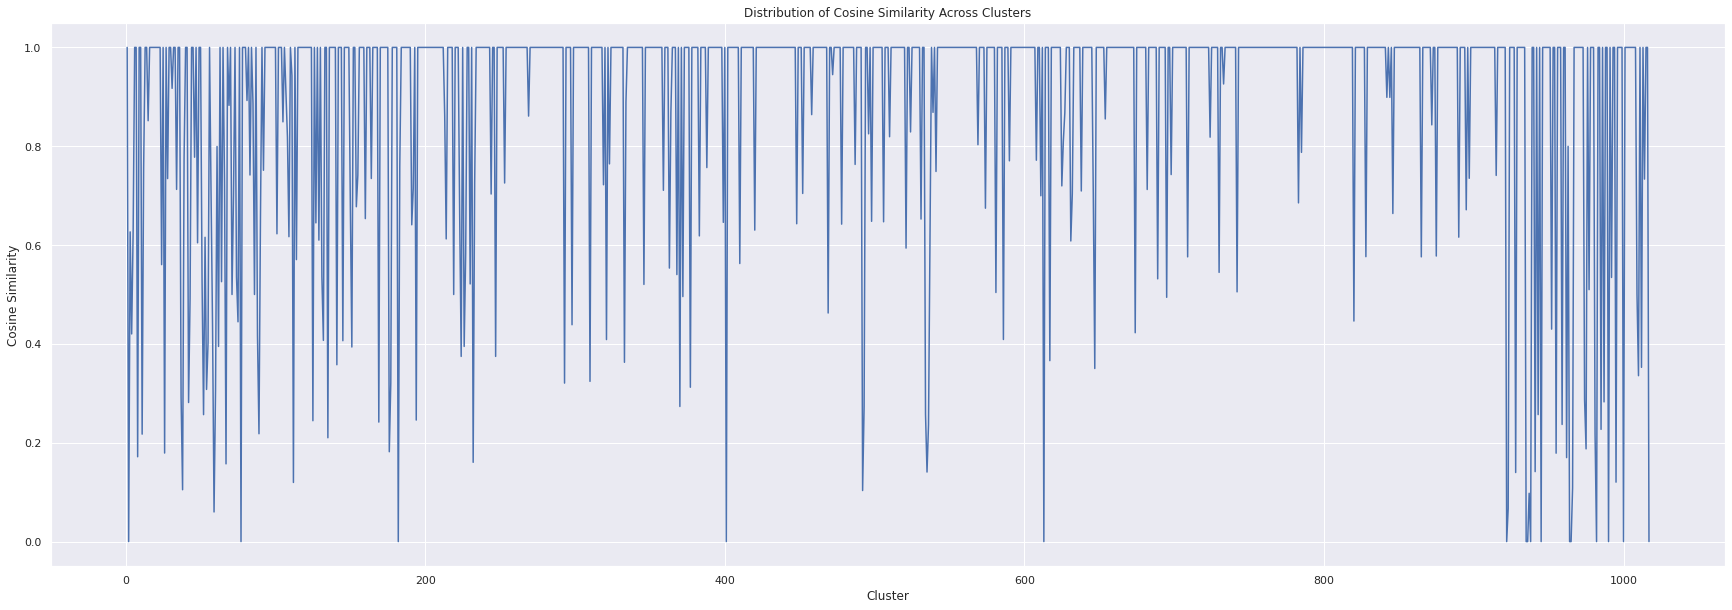

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30,10)
y=np.arange(1,n_clusters_+2)
np.append(y, -1)
# sns.lineplot(y, sim)
fig = plt.plot(y,sim)
plt.xlabel('Cluster')
plt.ylabel('Cosine Similarity')
plt.title('Distribution of Cosine Similarity Across Clusters')
plt.savefig('final_data_cluster_cosine.png')

In [ ]:
new_df = df

In [ ]:
# new_df=pd.read_csv("/content/drive/MyDrive/Infragistics/com_labeled_data.csv")
# new_df=new_df.drop(columns=['Unnamed: 0'])

Final dataframe with labels

In [ ]:
new_df

,input,reply,label
0,yeah true did you know babies are really good ...,yes and they smile more when they hit the beat,0
1,yes it helped him smooth out his dance moves,nice do you like shakespeare,1
2,yes otherwise the rhymes and puns do not seem ...,yes he lived at the same time as pocahontas too,-1
3,ha ha it was so nice chatting with you as well...,bye,1
4,i love it did you know bruce lee was a dancer,yes he even won a cha cha championship in 1958,-1
...,...,...,...
58713,will this unit work with usb 20,yes it will,1
58714,is this compatible with the iconia 510 tablet,yes it is,69
58715,will this power supply work on my hp pavilion ...,it should,930
58716,are there any video out ports hdmi or vga,yes both,1


# LSTM model

In [ ]:
#loading Packages
from __future__ import print_function
from __future__ import division

import math
import pickle
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import Counter
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pack_padded_sequence, invert_permutation
from torch.nn.utils import clip_grad_norm_

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)

from nltk.translate.bleu_score import sentence_bleu

In [ ]:
#checking maximum legth of sentences in incoming messages
source_text = [sentence.split(' ') for sentence in new_df.input]
seq_len=max([len(sentence) for sentence in source_text])
print(seq_len)

50


## Tokenization of incoming messages

In [ ]:
import spacy
spacy_en = spacy.load('en_core_web_sm')
import torchtext as tt
from collections import Counter
import functools
import operator

In [ ]:
def spacy_tokenizer(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [ ]:
TEXT = tt.legacy.data.Field(
  tokenize    = spacy_tokenizer,
  lower       = True,
  batch_first = True,
  init_token  = '<bos>',
  eos_token   = '<eos>',
  fix_length  = seq_len
)

Splitting data into training - validation and test in 70-20-10 ratio

In [ ]:
from sklearn.model_selection import train_test_split

input_train, input_temp, label_train, label_temp = train_test_split(new_df.input, new_df.label, train_size=0.7)
input_val, input_test, label_val, label_test  = train_test_split(input_temp, label_temp, test_size=0.4)

label_train = label_train.astype(int)
label_val = label_val.astype(int)
label_test = label_test.astype(int)

In [ ]:
minibatch = new_df.input
minibatch = list(map(TEXT.preprocess, minibatch))
minibatch = TEXT.pad(minibatch)

In [ ]:
TEXT.build_vocab(minibatch)
vocab= TEXT.vocab

In [ ]:
vocab_len=len(vocab)
print(vocab_len)

28178


Function turns incoming messages to tensors

In [ ]:
def numer(input_series):
    temp = input_series
    temp = list(map(TEXT.preprocess, temp))
    temp = TEXT.pad(temp)
    return  TEXT.numericalize(temp)

we replace the cluster number -1 with Number of clusters value which 1016. Becuase 1016 clusters formed from 0-1015. -1 cluster will be added as no. of clusters +1 =1017th cluster. Thsi fucntion turns label column to tensor.

In [ ]:
def label_tensor(label_array):
    x = np.where(label_array.values == -1, n_clusters_, label_array.values)
    x = torch.tensor(x)
    return x

In [ ]:
input_train_ten = numer(input_train)
label_train_ten = label_tensor(label_train)

input_val_ten = numer(input_val)
label_val_ten = label_tensor(label_val)

input_test_ten = numer(input_test)
label_test_ten = label_tensor(label_test)

Loading data into dataloaders

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor

train_dataset = TensorDataset(input_train_ten,label_train_ten)

train_loader = DataLoader(train_dataset,shuffle=False, batch_size= 100)

val_dataset = TensorDataset(input_val_ten,label_val_ten)

val_loader = DataLoader(val_dataset,shuffle=False, batch_size= 100)

test_dataset = TensorDataset(input_test_ten,label_test_ten)

test_loader = DataLoader(test_dataset,shuffle=False, batch_size= 100)

In [ ]:
class EncoderLSTM(nn.Module):
  
    def __init__(self, embedding_dim, hidden_size, vocab_size=vocab_len):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=1)  # word embeddings
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
        self.out= nn.Linear(hidden_size, n_clusters_+1)
        self.hidden_size= hidden_size
        self.softmax = nn.Softmax(dim=1)

    
    def forward(self, source_text, label_ten):
        # type: (Tensor, Tensor) -> Tuple[Tensor, Tuple[Tensor, Tensor]]
        loss = None

        embedded = self.embedding(source_text)
        N = embedded.shape[0]

        hidden_state = source_text.new_zeros(N, self.hidden_size).float()
        cell_state = source_text.new_zeros(N, self.hidden_size).float()
        hidden_state= hidden_state.unsqueeze(0)
        cell_state = cell_state.unsqueeze(0)

        hidden_states, (hT, cT) = self.lstm(embedded, (hidden_state, cell_state))
        hT = hT.squeeze(0)
        final = self.out(hT)
        
        criterion = nn.CrossEntropyLoss()
        loss = criterion(final , label_ten)
        return loss
    def predict(self, source_text):
        embedded = self.embedding(source_text)
        N = embedded.shape[0]

        hidden_state = source_text.new_zeros(N, self.hidden_size).float()
        cell_state = source_text.new_zeros(N, self.hidden_size).float()
        hidden_state= hidden_state.unsqueeze(0)
        cell_state = cell_state.unsqueeze(0)

        hidden_states, (hT, cT) = self.lstm(embedded, (hidden_state, cell_state))
        hT = hT.squeeze(0)
        final = self.out(hT)
      
        _, labels_pred = torch.topk(final, 4, dim=1, largest=True, sorted=True)
        return labels_pred

In [ ]:
import torch.optim as optim

Evaluation fucntion for model which genrates validation accuracy by testing the model at any point on validation dataset

In [ ]:
def eval_acc(model):
    with torch.no_grad():
      model.eval()
      total = 0
      correct = 0
      for (input_val_ten, label_val_ten) in val_loader:
        input_val_ten = input_val_ten.cuda()
        label_val_ten = label_val_ten.cuda()

        labels_predicted = model.predict(input_val_ten)
        total += label_val_ten.shape[0]

        labels_predicted = labels_predicted.cpu().numpy()
        label_val_num = label_val_ten.cpu().numpy()
        
        for index, x in np.ndenumerate(label_val_num):
          if x in labels_predicted[index]:
            correct = correct+1
      
      acc = 100 * correct / total
    return acc

Different Evaluation fucntion that checks for cosine simiarlty also but skipped because takes longer time to train

In [ ]:
# def eval_acc(model):
#     with torch.no_grad():
#       model.eval()
#       total = 0
#       correct = 0
#       cosine_sim=[]
#       for (input_val_ten, label_val_ten) in val_loader:
#         input_val_ten = input_val_ten.cuda()
#         label_val_ten = label_val_ten.cuda()

#         labels_predicted = model.predict(input_val_ten)
#         total += label_val_ten.shape[0]

#         labels_predicted = labels_predicted.cpu().numpy()
#         label_val_num = label_val_ten.cpu().numpy()
#         for index in range(len(labels_predicted)):
#           cs= np.median([sim[labels_predicted[index][0]],sim[labels_predicted[index][1]],sim[labels_predicted[index][2]]])
#           cosine_sim.append(cs)

#         score_list=[]

#         for index, x in np.ndenumerate(label_val_num):
#           if x in labels_predicted[index]:
#             correct = correct+1
#           if x==n_clusters_:
#             class_member_mask = (labels == -1)
#             gt_sen = [i.split(' ') for i in new_df.reply[class_member_mask].values]
#           else:
#             class_member_mask = (labels == x)
#             gt_sen = new_df.reply[class_member_mask].sample(n=1).values[0].split(' ')
                
#           bleu_list=[]
#           adjusted_preds = np.where(labels_predicted[index]==n_clusters_, -1, labels_predicted[index])
#           for j in range(len(adjusted_preds)):
#             class_member_mask = (labels == adjusted_preds[j])
#             out_sen=new_df.reply[class_member_mask].sample(n=1).values[0].split(' ')
#             score = sentence_bleu(gt_sen, out_sen)
#             bleu_list.append(score)
          
#           max_score = max(bleu_list)
#           score_list.append(max_score)

#       final_score = sum(score_list) / len(score_list)
#       acc = 100 * correct / total
#     return acc, final_score, np.mean(cosine_sim)


## Training the model

Train Epoch:   0 	 Loss: 6.859248 	 Val Acc: 0.085155
Train Epoch:   1 	 Loss: 2.138427 	 Val Acc: 69.826852
Train Epoch:   2 	 Loss: 2.134595 	 Val Acc: 69.826852
Train Epoch:   3 	 Loss: 2.132777 	 Val Acc: 69.836314
Train Epoch:   4 	 Loss: 2.131739 	 Val Acc: 69.845775
Train Epoch:   5 	 Loss: 2.016721 	 Val Acc: 70.044470
Train Epoch:   6 	 Loss: 1.928300 	 Val Acc: 71.861103
Train Epoch:   7 	 Loss: 1.877419 	 Val Acc: 73.091116
Train Epoch:   8 	 Loss: 1.799976 	 Val Acc: 73.488504
Train Epoch:   9 	 Loss: 1.760334 	 Val Acc: 74.169742
Train Epoch:  10 	 Loss: 1.678181 	 Val Acc: 74.945596
Train Epoch:  11 	 Loss: 1.632410 	 Val Acc: 74.794209
Train Epoch:  12 	 Loss: 1.561469 	 Val Acc: 74.775286
Train Epoch:  13 	 Loss: 1.519847 	 Val Acc: 74.803671
Train Epoch:  14 	 Loss: 1.465958 	 Val Acc: 74.822594


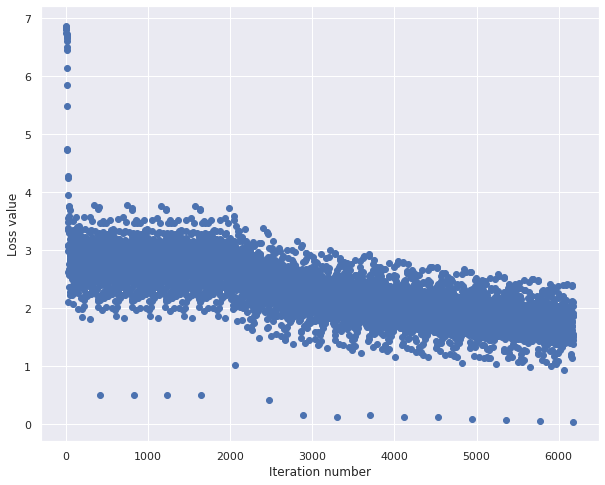

In [ ]:
torch.manual_seed(0)
model = EncoderLSTM(128,128)
model = model.cuda()
num_epochs = 15
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

loss_history = []
for epoch in range(num_epochs):
    # val_acc, bleu_score, cosine_similarity = eval_acc(model)
    val_acc=eval_acc(model)
    model.train()

    for batch, (input_train_ten, label_train_ten) in enumerate(train_loader):
        input_train_ten = input_train_ten.cuda()
        label_train_ten = label_train_ten.cuda()

        optimizer.zero_grad()
        loss = model(input_train_ten, label_train_ten)
        loss.backward()
        optimizer.step()
        # wandb.log({"val_acc": val_acc, "loss": loss})
        # wandb.watch(model)

        with torch.no_grad():
            loss_history.append(loss.item())
            if batch == 0:
                # print('Train Epoch: {:3} \t Loss: {:F} \t Val Acc: {:F}  \t BLEU Score: {:F} \t Cosine Similarity: {:F}'.format(epoch, loss.item(), val_acc, bleu_score, cosine_similarity))
                print('Train Epoch: {:3} \t Loss: {:F} \t Val Acc: {:F}'.format(epoch, loss.item(), val_acc))

with torch.no_grad():
    plt.plot(loss_history, 'o')
    plt.xlabel('Iteration number')
    plt.ylabel('Loss value')
    plt.show()

## Hyperparameter Tuning using WandB
**`Should be skipped if there isn't WandB avaliable`**

In [ ]:
%%capture
!pip install wandb --upgrade

# workaround to fetch MNIST data
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

In [ ]:
sweep_config = {
    'method': 'random'
    }

In [ ]:
metric = {
    'name': 'val_acc',
    'goal': 'maximize'   
    }

sweep_config['metric'] = metric

Loading parameters for wandB sweeps and Hyperparameter tuning

`**can be skipped**`

In [ ]:
parameters_dict = {
    'epochs': {'values': [15,25]},
    'optimizer': {
        'values': ['adam','sgd']
        },
    'hidden_size': {
        'values': [128, 256]
        },
    'embedding_dim': {
          'values': [128,256]
        },
      'learning_rate': {
            'values': [0.01, 0.001]
    }
}
sweep_config['parameters'] = parameters_dict

Hyperparameters ranges for WandB Sweeps

In [ ]:
import pprint

pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'maximize', 'name': 'val_acc'},
 'parameters': {'embedding_dim': {'values': [128, 256]},
                'epochs': {'values': [15, 25]},
                'hidden_size': {'values': [128, 256]},
                'learning_rate': {'values': [0.01, 0.001]},
                'optimizer': {'values': ['adam', 'sgd']}}}


Sweep_Id generates wandb Sweep unqiue ID. Not needed to run the model

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="Combined-data-LSTM", entity="smartreply")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: ajv9becj
Sweep URL: https://wandb.ai/smartreply/Combined-data-LSTM/sweeps/ajv9becj


In [ ]:
def train(config=None):

    with wandb.init(project='Combined-data-LSTM', entity='smartreply', config=config):
        config = wandb.config
        torch.manual_seed(0)
        model = EncoderLSTM(config.embedding_dim, config.hidden_size)
        model = model.cuda()
        optimizer = optim.SGD(model.parameters(), lr=config.learning_rate)

        if config.optimizer == "sgd":
            optimizer = optim.SGD(model.parameters(),
                                  lr=config.learning_rate, momentum=0.9)
        elif optimizer == "adam":
            optimizer = optim.Adam(model.parameters(),
                                   lr=config.learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
        loss_history = []
        for epoch in range(config.epochs):
          # val_acc, bleu_score, cosine_similarity = eval_acc(model)
          val_acc=eval_acc(model)
          model.train()

          for batch, (input_train_ten, label_train_ten) in enumerate(train_loader):
              input_train_ten = input_train_ten.cuda()
              label_train_ten = label_train_ten.cuda()

              optimizer.zero_grad()
              loss = model(input_train_ten, label_train_ten)
              loss.backward()
              optimizer.step()
              wandb.log({"val_acc": val_acc, "loss": loss})
              wandb.watch(model)

              with torch.no_grad():
                  loss_history.append(loss.item())
                  if batch == 0:
                      # print('Train Epoch: {:3} \t Loss: {:F} \t Val Acc: {:F}  \t BLEU Score: {:F} \t Cosine Similarity: {:F}'.format(epoch, loss.item(), val_acc, bleu_score, cosine_similarity))
                      print('Train Epoch: {:3} \t Loss: {:F} \t Val Acc: {:F}'.format(epoch, loss.item(), val_acc))

        print('Finished Training')


In [ ]:
wandb.agent(sweep_id, function=train, count=10)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: ormo11il with config:
wandb: 	embedding_dim: 256
wandb: 	epochs: 25
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


Train Epoch:   0 	 Loss: 6.938121 	 Val Acc: 0.047308
Train Epoch:   1 	 Loss: 3.085399 	 Val Acc: 69.694389
Train Epoch:   2 	 Loss: 2.923395 	 Val Acc: 69.694389
Train Epoch:   3 	 Loss: 2.752205 	 Val Acc: 69.694389
Train Epoch:   4 	 Loss: 2.685988 	 Val Acc: 69.694389
Train Epoch:   5 	 Loss: 2.656149 	 Val Acc: 69.694389
Train Epoch:   6 	 Loss: 2.644352 	 Val Acc: 69.694389
Train Epoch:   7 	 Loss: 2.639444 	 Val Acc: 69.694389
Train Epoch:   8 	 Loss: 2.637548 	 Val Acc: 69.694389
Train Epoch:   9 	 Loss: 2.637467 	 Val Acc: 69.694389


## Filtering reply Clusters
Loading a dataframe which has details and default replies for rel;evant clusters

In [ ]:
filter_df= pd.read_csv('/content/drive/MyDrive/Infragistics/cluster_filter.csv')

In [ ]:
filter_df

,cluster,relevancy,default_replies
0,0,0,NaN
1,1,0,NaN
2,2,1,"thank you for chatting with me, have a nice day"
3,3,1,I dint know that
4,4,1,no what is it
...,...,...,...
1011,1011,0,NaN
1012,1012,0,NaN
1013,1013,1,it should work
1014,1014,0,NaN


# Prediction Function from the model

Other fucntion which takes replies randomly from the clusters

In [ ]:
# def generate_suggestions_sent(Incoming_message):
#   inc = process(Incoming_message)

#   num_inc = numer([inc])

#   preds = model.predict(num_inc.cuda())

#   num_preds = preds.cpu().numpy()
#   adj_preds = np.where(num_preds ==n_clusters_, -1, num_preds)
#   adj_preds = adj_preds.squeeze(0)

#   sug=[None,None,None,None]
#   for i in range(len(adj_preds)):
#     if adj_preds[i]==-1:
#       sug[i]='ok'
#     else:
#       class_member_mask = (labels == adj_preds[i])
#       sug[i]= new_df.reply[class_member_mask].sample(n=1).values[0]
#   res =  [sug[0], sug[1], sug[2], sug[3]]
#   return [i for i in res if i]

Funtion that genrates replies for incoming messages fom default replies

In [ ]:
def generate_suggestions_sent(Incoming_message):
  inc = process(Incoming_message)

  num_inc = numer([inc])

  preds = model.predict(num_inc.cuda())

  num_preds = preds.cpu().numpy()
  #replacing 1016th cluster with -1 again to recognize -1 cluster replies
  adj_preds = np.where(num_preds ==n_clusters_, -1, num_preds)
  adj_preds = adj_preds.squeeze(0)

  sug=[0,0,0,0]
  for i in range(len(adj_preds)):
    if adj_preds[i]==-1:
      #setting deafult reply for -1 cluster as 'ok'
      sug[i]='ok'
    else:
      # class_member_mask = (labels == adj_preds[i])
      if filter_df['relevancy'][adj_preds[i]]==1:
        sug[i]= filter_df['default_replies'][adj_preds[i]]
      else:
        sug[i]=None
  res =  [sug[0], sug[1], sug[2], sug[3]]
  return [i for i in res if i]

Examples

In [ ]:
message = "Please join the zoom call!"
# have a great day
# good night take care
# good morning
# thank you have nice day
print(generate_suggestions_sent(message))

['ok', 'same here', 'yes it is ']


## Gradio Implementation

In [ ]:
import gradio as gr


iface = gr.Interface(
  fn=generate_suggestions_sent, 
  inputs=gr.inputs.Textbox(lines=2, placeholder="Type input message here..."), 
  outputs="text")
iface.launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://17854.gradio.app

This share link will expire in 72 hours. To get longer links, send an email to: support@gradio.app


(<Flask 'gradio.networking'>,
 'http://127.0.0.1:7860/',
 'https://17854.gradio.app')